In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="bk3G8rrLiKUqECCCLgcZ")
project = rf.workspace("yomna-hupf9").project("car-jcznw")
dataset = project.version(2).download("coco-segmentation")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 820.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to car-2 in coco-segmentation:: 100%|██████████| 6357/6357 [00:01<00:00, 3553.86it/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d8khxvu4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d8khxvu4
  Resolved https://github.com/facebookresearch/detectron2.git to commit e9f7e2ba15abd7badcb05ef6f5076f06b36a9c5b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 830.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119664 sha256=ba51cddee951f5daa4c2d31222c

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
import json

def is_coco_format(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Check if the main keys are present
        if not all(key in data for key in ["images", "annotations", "categories"]):
            return False

        # Check if 'images' has the required keys
        for image in data["images"]:
            if not all(key in image for key in ["height", "width", "id", "file_name"]):
                return False

        # Check if 'annotations' has the required keys
        for annotation in data["annotations"]:
            if not all(key in annotation for key in ["iscrowd", "image_id", "bbox", "category_id", "id", "area"]):
                return False

        # Check if 'categories' has the required keys
        for category in data["categories"]:
            if not all(key in category for key in ["id", "name"]):
                return False

        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [7]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)


from matplotlib import pyplot as plt
from PIL import Image

In [8]:
register_coco_instances("dataset_train", {}, f"/content/car-2/train/_annotations.coco.json", f"/content/car-2/train/")
register_coco_instances("dataset_valid", {}, f"/content/car-2/valid/_annotations.coco.json", f"/content/car-2/valid/")
register_coco_instances("dataset_test", {}, f"/content/car-2/test/_annotations.coco.json", f"/content/car-2/test/")

WARNING [12/29 16:45:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 16:45:56 d2.data.datasets.coco]: Loaded 5234 images in COCO format from /content/car-2/train/_annotations.coco.json


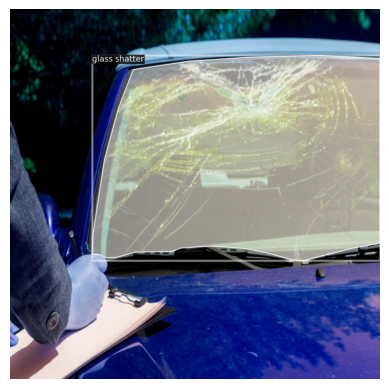

In [9]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Load the dataset and retrieve metadata
dataset_dicts = DatasetCatalog.get("dataset_train")
dataset_metadata = MetadataCatalog.get("dataset_train")

# Pick a random sample from the dataset
sample = random.choice(dataset_dicts)

# Read the image
img = cv2.imread(sample["file_name"])

# Create a Visualizer object
visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

# Visualize the annotations
vis_output = visualizer.draw_dataset_dict(sample)

# Display the image using Matplotlib
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy
import torch
from detectron2.data import detection_utils as utils

In [12]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomRotation(angle=[90, 180, 270]),  # Simple rotation
        T.RandomContrast(0.8, 1.2),             # Random contrast
        T.RandomBrightness(0.8, 1.2),           # Random brightness
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [13]:
def custom_train_loader(cfg):
    return build_detection_train_loader(cfg, mapper=custom_mapper)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return custom_train_loader(cfg)

In [14]:
# Define hyperparameters
batch_size = 8

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (3000, 4000)  # Points to decrease the learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# Learning rate scheduler configuration
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.1  # Learning rate reduction factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Regularization - weight decay

# Set up output directory
output_dir = "/content/drive/MyDrive/damaged_car"
os.makedirs(output_dir, exist_ok=True)
cfg.OUTPUT_DIR = output_dir

# Initialize the trainer and start training
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[12/29 16:45:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 175MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/29 16:45:59 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


[12/29 16:46:52 d2.utils.events]:  eta: 2:47:39  iter: 19  total_loss: 3.453  loss_cls: 2.04  loss_box_reg: 0.5732  loss_mask: 0.692  loss_rpn_cls: 0.1235  loss_rpn_loc: 0.02771    time: 2.2503  last_time: 1.9649  data_time: 0.2602  last_data_time: 0.1716   lr: 4.5417e-06  max_mem: 9474M
[12/29 16:47:36 d2.utils.events]:  eta: 2:48:39  iter: 39  total_loss: 3.359  loss_cls: 1.912  loss_box_reg: 0.5695  loss_mask: 0.6915  loss_rpn_cls: 0.1212  loss_rpn_loc: 0.02401    time: 2.1424  last_time: 2.1502  data_time: 0.2147  last_data_time: 0.2518   lr: 9.0592e-06  max_mem: 9474M
[12/29 16:48:19 d2.utils.events]:  eta: 2:48:36  iter: 59  total_loss: 2.981  loss_cls: 1.603  loss_box_reg: 0.5065  loss_mask: 0.6895  loss_rpn_cls: 0.08556  loss_rpn_loc: 0.02337    time: 2.1433  last_time: 2.1650  data_time: 0.2141  last_data_time: 0.2392   lr: 1.3577e-05  max_mem: 9475M
[12/29 16:49:01 d2.utils.events]:  eta: 2:48:54  iter: 79  total_loss: 2.634  loss_cls: 1.26  loss_box_reg: 0.5486  loss_mask: 0

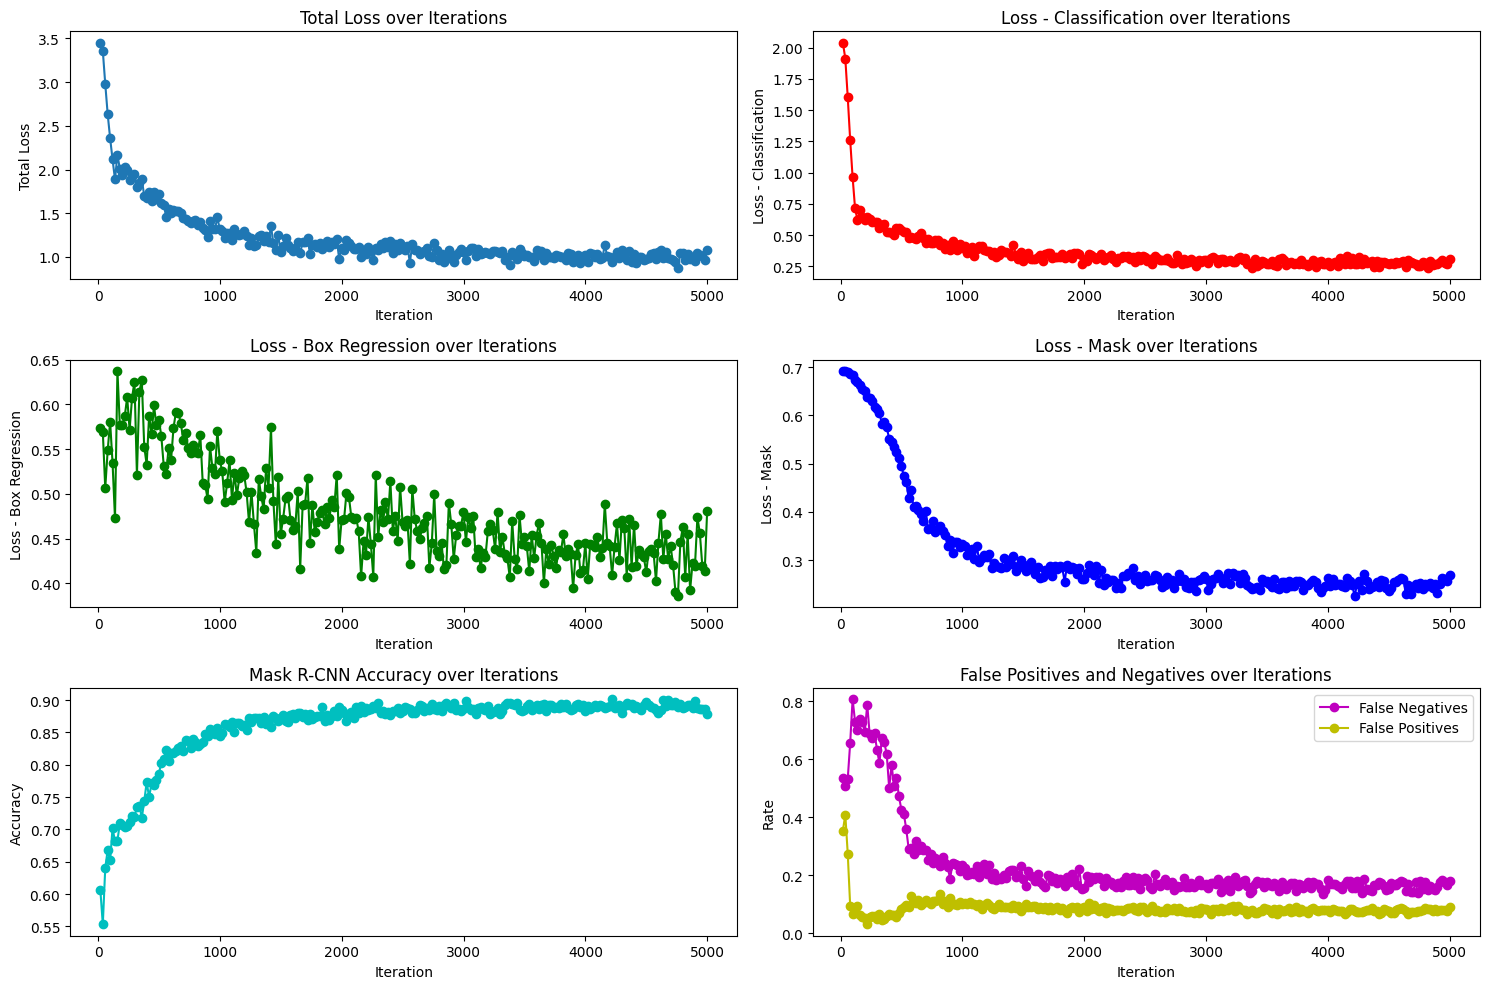

In [18]:
import json
import matplotlib.pyplot as plt

# Path to your JSON file
json_file_path = '/content/drive/MyDrive/damaged_car/metrics.json'

# Read data from JSON file
json_data = []
with open(json_file_path, 'r') as file:
    for line in file:
        json_data.append(json.loads(line))

# Extracting data
iterations = [d["iteration"] for d in json_data]
total_losses = [d["total_loss"] for d in json_data]
loss_cls = [d["loss_cls"] for d in json_data]
loss_box_reg = [d["loss_box_reg"] for d in json_data]
loss_mask = [d["loss_mask"] for d in json_data]
accuracies = [d["mask_rcnn/accuracy"] for d in json_data]
false_negatives = [d["mask_rcnn/false_negative"] for d in json_data]
false_positives = [d["mask_rcnn/false_positive"] for d in json_data]

# Plotting
plt.figure(figsize=(15, 10))

# Total Loss
plt.subplot(3, 2, 1)
plt.plot(iterations, total_losses, marker='o')
plt.title('Total Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')

# Loss - Classification
plt.subplot(3, 2, 2)
plt.plot(iterations, loss_cls, marker='o', color='r')
plt.title('Loss - Classification over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Classification')

# Loss - Box Regression
plt.subplot(3, 2, 3)
plt.plot(iterations, loss_box_reg, marker='o', color='g')
plt.title('Loss - Box Regression over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Box Regression')

# Loss - Mask
plt.subplot(3, 2, 4)
plt.plot(iterations, loss_mask, marker='o', color='b')
plt.title('Loss - Mask over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Mask')

# Accuracy
plt.subplot(3, 2, 5)
plt.plot(iterations, accuracies, marker='o', color='c')
plt.title('Mask R-CNN Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# False Positives and False Negatives
plt.subplot(3, 2, 6)
plt.plot(iterations, false_negatives, marker='o', color='m', label='False Negatives')
plt.plot(iterations, false_positives, marker='o', color='y', label='False Positives')
plt.title('False Positives and Negatives over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [20]:
# Initialize the configuration
cfg = get_cfg()

# Load the base configuration from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the path to the trained model weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/damaged_car/model_0004999.pth"

# Set the number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Update this based on your dataset

# Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Specify the test dataset
cfg.DATASETS.TEST = ("my_dataset_val",)

In [21]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

[12/29 19:54:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/damaged_car/model_0004999.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [12/29 19:55:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 19:55:30 d2.data.datasets.coco]: Loaded 745 images in COCO format from /content/car-2/valid/_annotations.coco.json


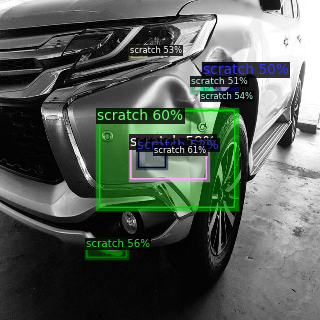

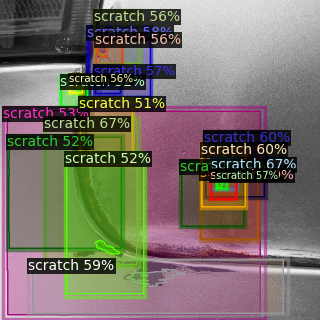

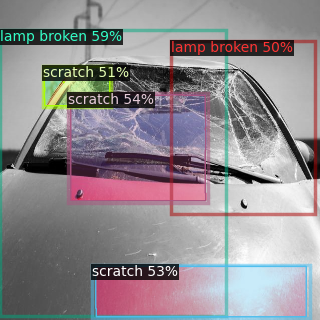

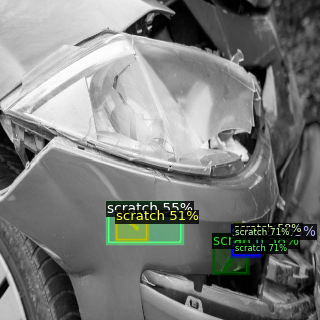

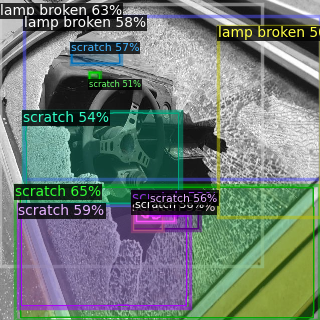

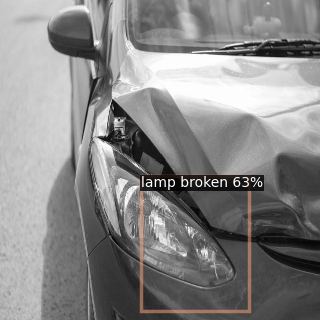

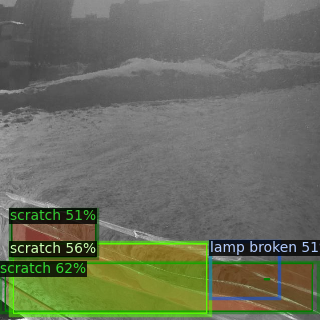

In [22]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import random
import cv2

# Name of the validation dataset
dataset_name = "dataset_valid"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [24]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Create a COCOEvaluator instance for your test dataset
evaluator = COCOEvaluator("dataset_valid", cfg, False, output_dir="/content/drive/MyDrive/output1/evaluation")

# Build the test data loader
test_loader = build_detection_test_loader(cfg, "dataset_valid")

# Run the model on the test data and get the evaluation metrics
inference_on_dataset(predictor.model, test_loader, evaluator)

WARNING [12/29 20:00:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/29 20:00:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 20:00:59 d2.data.datasets.coco]: Loaded 745 images in COCO format from /content/car-2/valid/_annotations.coco.json
[12/29 20:00:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/29 20:00:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/29 20:00:59 d2.data.common]: Serializing 745 elements to byte tensors and concatenating them all ...
[12/29 20:00:59 d2.data.common]: Serialized dataset takes 1.58 MiB
[12/29 20:00:59 d2.evaluation.evaluator]: Start inference on 745 batches


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[12/29 20:01:01 d2.evaluation.evaluator]: Inference done 11/745. Dataloading: 0.0027 s/iter. Inference: 0.1318 s/iter. Eval: 0.0161 s/iter. Total: 0.1506 s/iter. ETA=0:01:50
[12/29 20:01:06 d2.evaluation.evaluator]: Inference done 50/745. Dataloading: 0.0036 s/iter. Inference: 0.1173 s/iter. Eval: 0.0104 s/iter. Total: 0.1314 s/iter. ETA=0:01:31
[12/29 20:01:12 d2.evaluation.evaluator]: Inference done 93/745. Dataloading: 0.0030 s/iter. Inference: 0.1122 s/iter. Eval: 0.0099 s/iter. Total: 0.1252 s/iter. ETA=0:01:21
[12/29 20:01:17 d2.evaluation.evaluator]: Inference done 132/745. Dataloading: 0.0033 s/iter. Inference: 0.1142 s/iter. Eval: 0.0098 s/iter. Total: 0.1274 s/iter. ETA=0:01:18
[12/29 20:01:22 d2.evaluation.evaluator]: Inference done 166/745. Dataloading: 0.0038 s/iter. Inference: 0.1179 s/iter. Eval: 0.0105 s/iter. Total: 0.1324 s/iter. ETA=0:01:16
[12/29 20:01:27 d2.evaluation.evaluator]: Inference done 208/745. Dataloading: 0.0035 s/iter. Inference: 0.1162 s/iter. Eval: 0.

OrderedDict([('bbox',
              {'AP': 0.06788750320816538,
               'AP50': 0.3631742039159763,
               'AP75': 0.00289398433854368,
               'APs': 0.12467913458012467,
               'APm': 0.01868050636905559,
               'APl': 0.07572375467435401,
               'AP-damage-in-cars': nan,
               'AP-crack': 0.0,
               'AP-dent': 0.0,
               'AP-glass shatter': 0.0,
               'AP-lamp broken': 0.3476724142038178,
               'AP-scratch': 0.0596526050451745,
               'AP-tire flat': 0.0}),
             ('segm',
              {'AP': 0.0005235611987796639,
               'AP50': 0.004050405040504051,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0005438309194681464,
               'APl': 0.0008510143437060951,
               'AP-damage-in-cars': nan,
               'AP-crack': 0.0,
               'AP-dent': 0.0,
               'AP-glass shatter': 0.0,
               'AP-lamp broken': 0.0

WARNING [12/29 20:12:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 20:12:49 d2.data.datasets.coco]: Loaded 370 images in COCO format from /content/car-2/test/_annotations.coco.json


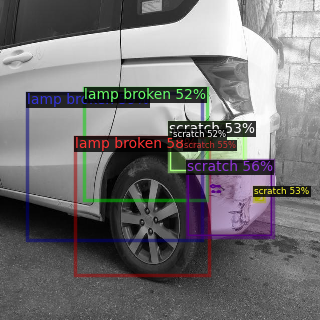

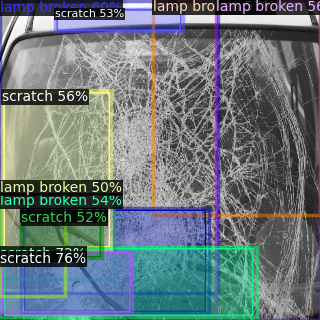

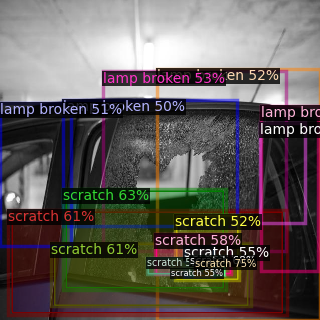

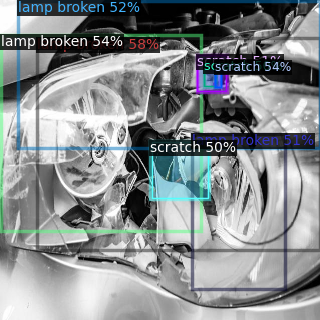

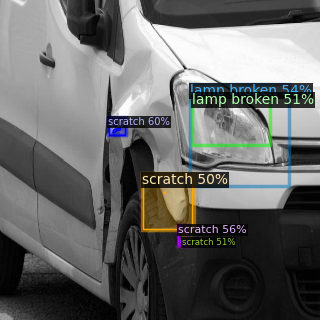

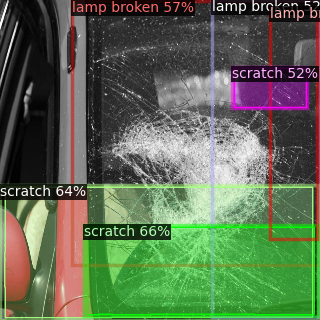

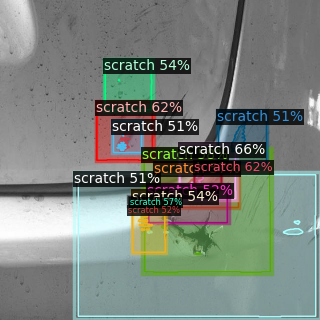

In [27]:
# Name of the validation dataset
dataset_name = "dataset_test"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])